In [41]:
import numpy as np
from obspy import read
from obspy.io.xseed import Parser
from obspy.imaging.spectrogram import _nearest_pow_2
from scipy import signal
import obspy
import matplotlib.pyplot as plt
from IPython.display import Image

from matplotlib import mlab, transforms
plt.rcParams['image.cmap'] = 'inferno'
import math as M
import matplotlib as mpl
import numpy.ma as ma

from func.def_master import sorting_out_peaks, searchmaxima

In [42]:
station = 'KNR07'
component = 'BHZ'
year = 2017
day = '069'
day = str(day)
year= str(year)
pre_filt=(.005,.006,20,25) #before response remove
data_decimate_factor = 2
freq_min_bandpass = .9
freq_max_bandpass = 10

## Loading Data in loop and decimate it to 25Hz by factor 2_2018-09-13

In [43]:
#start_day = str(day)

year = str(year)

number_of_days = 1




per_lap = .1




freq_minimal_value = 3
distance = 120
maxima= 1
decimate_factor = 1e-15


for i in range(number_of_days):
    print(day)
    ## Depends on workstation 
    #st_BHZ = read('../../2016/1B/' + station + '/' + component + '.D/1B.' + station + '..' + component + '.D.' + year + '.' + start_day)
    st_BHZ = read('/data/cen/u254/Essing/AWI/KNIPA_NEW/' + year + '/1B/' + station + '/' + component + '.D/1B.' + station + '..' + component + '.D.' + year + '.' + day)
    #parser01_BHZ = Parser('../../TEST_DATA/Resp/RESP.1B.' + station + '..' + component)
    resp_file = ('/data/cen/u254/Essing/AWI/CAL/RESP.1B.' + station + '..' + component)
    st_BHZ = st_BHZ.decimate(factor=data_decimate_factor)
    fs = int(st_BHZ[0].stats.sampling_rate)
    st_BHZ_simu = st_BHZ.copy()
    st_BHZ_simu.simulate(paz_remove=None, pre_filt=pre_filt, seedresp={'filename': resp_file, 'units': 'DIS'})
    st_BHZ_simu_filt = st_BHZ_simu.copy()
    st_BHZ_simu_filt = st_BHZ_simu_filt.filter('bandpass',freqmin=freq_min_bandpass, freqmax=freq_max_bandpass)
    data_BHZ = np.array(st_BHZ_simu_filt[0].data)
    data_BHZ -= data_BHZ.mean()
    
    npts = len(data_BHZ)
    wlen = float(fs*3)
    nfft = int(_nearest_pow_2(wlen * fs))
    nlap = int(nfft * float(per_lap))
    # hanning window is set to default in mlab.specgram
    specgram_BHZ, freq, time = mlab.specgram(data_BHZ, Fs=fs, NFFT=nfft, noverlap=0)
    #print(np.shape(specgram_BHZ))
    specgram_BHZ_masekd = ma.array(specgram_BHZ)
    specgram_BHZ_masekd[0:1000,:] = ma.masked
    specgram_BHZ_masekd[1300:np.shape(specgram_BHZ)[0],:] = ma.masked
    
    threshold = np.amax(specgram_BHZ_masekd)*decimate_factor
    max_array_Z_masked, amp_values,frequency_indices, frequency_values = sorting_out_peaks(input_data=specgram_BHZ_masekd, freq_vec=freq, maxima=maxima, distance = distance, threshold = threshold, freq_minimal_value = freq_minimal_value)
    
    

    
    
    
    if i==0:
        first_date = st_BHZ[0].stats.endtime.ctime()[4:]
        all_days_amp_values = np.zeros((number_of_days, len(amp_values)))
        all_days_freq_values = np.zeros((number_of_days, len(frequency_values)))
        time_stack = time
        
        # set first specgram to specgram_merged
        
        specgram_merged = specgram_BHZ
        
    else:
        specgram_merged = np.append(specgram_merged, specgram_BHZ, axis=1)
    
    
    if i!=0:
        time_stack = np.append(time_stack, time_stack[-1]+time)

    
    all_days_amp_values[i,:] = amp_values
    all_days_freq_values[i,:] = frequency_values
                                       
                                       
    
    
    
    
    

069


/home/zmaw/u300967/.conda/envs/vgseis_2018/lib/python3.6/site-packages/obspy/signal/detrend.py:31: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(data.dtype, float):


In [44]:
lower_minval_freq = 0
lower_maxval_freq = .4
lower_freq_values = freq[np.where(np.logical_and(freq>lower_minval_freq, freq<lower_maxval_freq))]

upper_minval_freq = 1.8
upper_maxval_freq = 12.5
upper_freq_values = freq[np.where(np.logical_and(freq>upper_minval_freq, freq<upper_maxval_freq))]

In [45]:
lower_first_indi_to_use = np.where(freq == lower_freq_values[0])[0]
lower_last_indi_to_use = np.where(freq == lower_freq_values[-1])[0]

upper_first_indi_to_use = np.where(freq == upper_freq_values[0])[0]
upper_last_indi_to_use = np.where(freq == upper_freq_values[-1])[0]



funda_freq_amp_masekd = ma.array(specgram_BHZ)
funda_freq_amp_masekd[int(lower_first_indi_to_use):int(lower_last_indi_to_use),:] = ma.masked
funda_freq_amp_masekd[int(upper_first_indi_to_use):int(upper_last_indi_to_use),:] = ma.masked

## Just for 1d array

In [46]:
def searchmaxima1(maxima, distance, data, scale_vector=0):
    
    '''
    To find maxima in data, with option to give vecotr with scaling values for x-Axis
    
    Input:
    maxima    scalar        value of maxima to find
    distance  scalar        value for nearest next maxima to search for
    data      1-D array     numpy array of data 
    freqvec   1-D array     numpy array of data with values to scale x-Axis (optional)
    
    '''

    index_max = np.zeros(maxima)
    value_max_f = np.zeros(maxima)
    value_max = np.zeros(maxima)
    data1 = data.copy()
    
    if type(scale_vector) == int:
    
        for i in range(maxima):
            index_max[i] = np.argmax((data1))
            value_max[i] = np.max((data1))
            #index_max[i] = np.argmax(Pxx_sig1)
            #value_max_f[i] = freqvec[np.argmax(data1)]
            #value_max[i] = np.max(Pxx_sig1)

            minimal_value = np.min(data1)

            data1[int(index_max[i]-distance):int(index_max[i]+distance)] = minimal_value-100
        return(value_max, index_max)
    
    else:
        for i in range(maxima):
            index_max[i] = np.argmax((data1))
            value_max[i] = np.max((data1))
            value_max_f[i] = scale_vector[np.argmax(data1)]
            minimal_value = np.min(data1)
        
            data1[int(index_max[i]-distance):int(index_max[i]+distance)] = minimal_value-100
            
        return(value_max, index_max,value_max_f)

In [47]:
input_data = funda_freq_amp_masekd

print(np.shape(input_data)[1])

amp_values = np.zeros((np.shape(input_data)[1]))
frequency_indices = np.zeros_like(amp_values)
frequency_values = np.zeros_like(amp_values)
max_array = np.zeros_like(input_data)


for j in range(np.shape(input_data)[1]):

    amp_values[j], frequency_indices[j], frequency_values[j] = searchmaxima1(maxima=1, distance=15, data=funda_freq_amp_masekd[:,j], scale_vector=freq)

1054


In [48]:
print(np.nan)

nan


In [49]:
def sorting_out_peaks1(input_data, freq_vec, maxima, distance ,threshold, freq_minimal_value):
    '''
    Calls searchmaxima and just hands maxima values which meet with two options:
            #- if there is a maximum below a certain frequency value (freq_minimal_value)
            - if maximum amplitude value is higher then certain ampiltude (threshold) 
    
    
    '''
    amplitude_values_all = np.zeros((np.shape(input_data)[1]))
    frequency_indices = np.zeros_like(amp_values)
    frequency_values_all = np.zeros_like(amp_values)
    max_array = np.zeros_like(input_data)
    
    
    for j in range(np.shape(input_data)[1]):
        #win_average = np.mean(input_data.T[j])
        #if win_average < all_win_average:
        # not a good solution. deletes as well some instrument signal

        amplitude_values_all[j], frequency_indices[j], frequency_values_all[j] = searchmaxima(maxima=maxima, distance=distance, data=input_data[:,j], scale_vector=freq_vec)
        #print(frequency_values)
        #if any(frequency_values<freq_minimal_value) == True:
        
        frequency_values = frequency_values_all.copy()
        amplitude_values = amplitude_values_all.copy()
        
        for i in range(len(frequency_indices)):
            if amplitude_values[i] > threshold:
                max_array[int(frequency_indices[i]),j] = amplitude_values[i]
            else:
                frequency_values[i] = np.nan
                amplitude_values[i] = np.nan
        #else:
        #     frequency_values[i] = 0
    return (max_array, amplitude_values_all, amplitude_values, frequency_indices, frequency_values_all, frequency_values)

## for 2d array

In [50]:
np.log10(10**(-16))

-16.0

In [51]:
threshold = 10**(-12.8)
print(10*np.log10(threshold))
max_array, amplitude_values_all, amplitude_values, frequency_indices, frequency_values_all, frequency_values = sorting_out_peaks1(input_data=funda_freq_amp_masekd, freq_vec=freq, maxima=1, distance=0 ,threshold=threshold, freq_minimal_value=.5)

-128.0


KNR07.BHZ_starttime: 2017-03-09T23:59:59


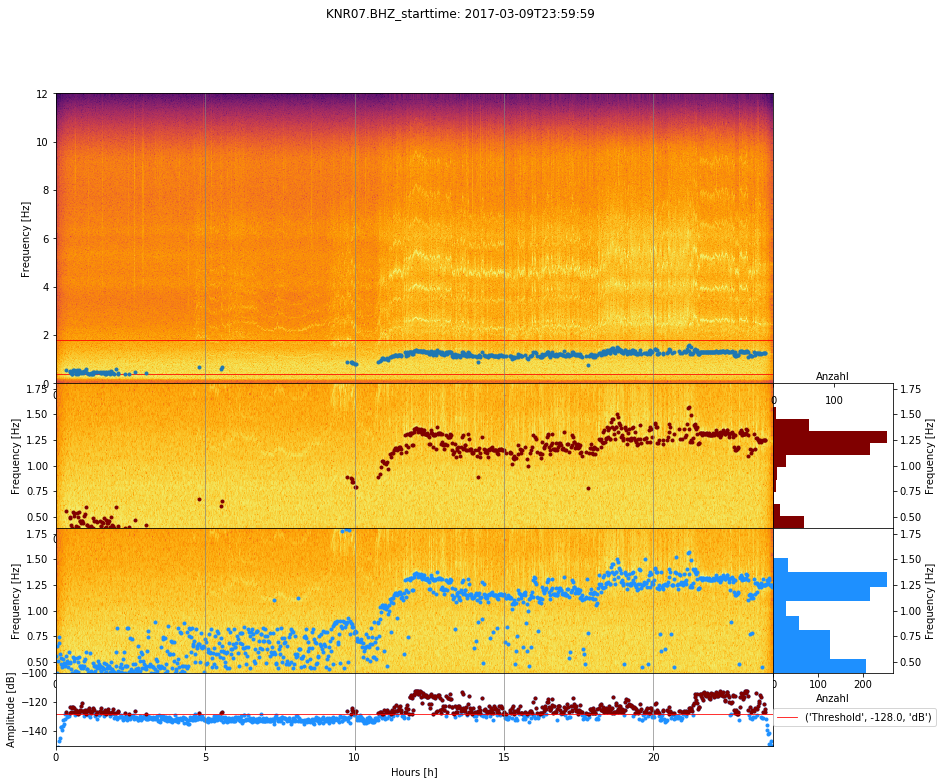

In [52]:
time_win = np.array([284,602,843])

number_bins= 10

color_set = ['maroon',  'grey',  'navy']

print(station + '.' + component + '_' + 'starttime: ' +  str(st_BHZ[0].stats.starttime)[0:19])
gridsize = (9, 7)
fig = plt.figure(figsize=(15, 12))
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle(station + '.' + component + '_' + 'starttime: ' +  str(st_BHZ[0].stats.starttime)[0:19])
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=6, rowspan=4)
#ax2 = plt.subplot2grid(gridsize, (0, 6), colspan=1, rowspan=4)
ax3 = plt.subplot2grid(gridsize, (4, 0), colspan=6, rowspan=2, sharex=ax1)
ax4 = plt.subplot2grid(gridsize, (4, 6), colspan=1, rowspan=2, sharey=ax3)
ax5 = plt.subplot2grid(gridsize, (6, 0), colspan=6, rowspan=2, sharex=ax1)
ax6 = plt.subplot2grid(gridsize, (6, 6), colspan=1, rowspan=2, sharey=ax3)
ax7 = plt.subplot2grid(gridsize, (8, 0), colspan=6, rowspan=1, sharex=ax1)




ax1.pcolormesh(time/3600, freq, 10*np.log10(specgram_BHZ))
ax1.axhline(y=freq[lower_last_indi_to_use], linewidth=.79, color='red')
ax1.axhline(y=freq[upper_first_indi_to_use], linewidth=.79, color='red')
#for i in range(len(time_win)):
    #ax1.axvline(x=time[time_win[i]]/3600, linewidth=.65, color=color_set[i])
ax1.axvline(x=5, linewidth=.65, color='grey')
ax1.axvline(x=10, linewidth=.65, color='grey')
ax1.axvline(x=15, linewidth=.65, color='grey')
ax1.axvline(x=20, linewidth=.65, color='grey')
ax1.plot(time/3600,frequency_values, '.')
ax1.set_ylabel('Frequency [Hz]')
#ax1.set_title(station + '.' + component + '_' + 'starttime: ' +  str(st_BHZ[0].stats.starttime)[0:19])
ax1.set_ylim(0,12)
#ax1.set_yticklabels([_,2,4,6,8,10,12])

#for i in range(len(time_win)):
    #print(amp_values[i], frequency_values[i])
    #ax2.plot(10*np.log10(specgram_BHZ[:,i]),freq, color=color_set[i], label=(round(float(time[time_win[i]]/3600), ndigits=2)))
    #ax2.plot(10*np.log10(amp_values[i]), frequency_values_all[i],  'o',color=color_set[i])
    #ax7.legend(bbox_to_anchor=(.5, -.2), loc='lower center', borderaxespad=0.)
#ax2.axhline(y=upper_minval_freq, linewidth=.99, color='red')
#ax2.axhline(y=lower_maxval_freq,  linewidth=.99, color='red')
#ax2.grid()
#ax2.set_xlim(-300,-150)
#ax2.set_ylim(lower_maxval_freq-.2, upper_minval_freq+.3)
#ax7.set_ylim(lower_maxval_freq, upper_minval_freq+.5)
#ax2.xaxis.tick_top()
#ax2.yaxis.tick_right()

ax3.pcolormesh(time/3600, freq, 10*np.log10(funda_freq_amp_masekd))
ax3.plot(time/3600,frequency_values,'.', color='maroon')
ax3.set_ylim(lower_maxval_freq-.01, upper_minval_freq)
ax3.axvline(x=5, linewidth=.65, color='grey')
ax3.axvline(x=10, linewidth=.65, color='grey')
ax3.axvline(x=15, linewidth=.65, color='grey')
ax3.axvline(x=20, linewidth=.65, color='grey')
#for i in range(len(time_win)):
    #ax3.axvline(x=time[time_win[i]]/3600, linewidth=.65, color=color_set[i])
ax3.set_ylabel('Frequency [Hz]')

#ax4.hist(frequency_values[~np.isnan(frequency_values)], bins=24, orientation='horizontal')
ax4.hist(frequency_values[~np.isnan(frequency_values)], bins=number_bins, color='maroon', orientation='horizontal')
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position('right')
ax4.set_ylabel('Frequency [Hz]')
ax4.xaxis.tick_top()
ax4.tick_params(axis="x",direction="in", pad=-22)
ax4.xaxis.set_label_position('top')
ax4.set_xlabel('Anzahl')

ax5.pcolormesh(time/3600, freq, 10*np.log10(funda_freq_amp_masekd))
ax5.plot(time/3600,frequency_values_all,'.', color='dodgerblue')
ax5.set_ylim(lower_maxval_freq-.01, upper_minval_freq)
ax5.axvline(x=5, linewidth=.65, color='grey')
ax5.axvline(x=10, linewidth=.65, color='grey')
ax5.axvline(x=15, linewidth=.65, color='grey')
ax5.axvline(x=20, linewidth=.65, color='grey')
#for i in range(len(time_win)):
    #ax5.axvline(x=time[time_win[i]]/3600, linewidth=.65, color=color_set[i])
ax5.set_ylabel('Frequency [Hz]')


ax6.hist(frequency_values_all, bins=number_bins, color='dodgerblue', orientation='horizontal')
#ax6.hist(frequency_values_all, bins=24, color='red', orientation='horizontal')
ax6.yaxis.tick_right()
ax6.yaxis.set_label_position('right')
ax6.set_ylabel('Frequency [Hz]')
ax6.set_xlabel('Anzahl')

ax7.plot(time/3600,10*np.log10(amplitude_values_all), '.', color='dodgerblue')
ax7.plot(time/3600,10*np.log10(amplitude_values), '.', color='maroon')
ax7.axhline(y=(10*np.log10(threshold)), linewidth=.8, color='red', label=('Threshold', 10*np.log10(threshold), 'dB'))
ax7.set_ylim(-150,-100)
#for i in range(len(time_win)):
    #ax7.axvline(x=time[time_win[i]]/3600, linewidth=.65, color=color_set[i])
ax7.axvline(x=5, linewidth=.65, color='grey')
ax7.axvline(x=10, linewidth=.65, color='grey')
ax7.axvline(x=15, linewidth=.65, color='grey')
ax7.axvline(x=20, linewidth=.65, color='grey')
ax7.set_xlim(0,24)
#ax7.set_ylim(10**-14,10**-11)
ax7.set_ylabel('Amplitude [dB]')
ax7.set_xlabel('Hours [h]')
ax7.legend(bbox_to_anchor=(1, 0.395), loc='center left', borderaxespad=0.)




plt.show()

In [ ]:
time_win = np.array([284,602,843])


plt.figure(figsize=(15,8))
for i in range(len(time_win)):
    #plt.plot(time/3600, 10*np.log10(amplitude_values_all[99]), '.')
    plt.plot(frequency_values_all[i],10*np.log10(amplitude_values_all[i]),'o', color=color_set[i], label=(round(float(time[time_win[i]]/3600), ndigits=2)))
    plt.plot(freq,10*np.log10(specgram_BHZ[:,i]), color=color_set[i])
    plt.xlim(0,3.5)
    plt.ylim(-280,-150)
plt.legend()
plt.show()

In [ ]:
gridsize = (2, 2)
fig = plt.figure(figsize=(15, 8))
fig.subplots_adjust(hspace=0)
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid(gridsize, (1, 0), colspan=2, rowspan=1, sharex=ax1)


ax1.hist(frequency_values_all, bins=50)
ax1.set_ylim(0,75)
ax1.grid()
ax2.hist(frequency_values[~np.isnan(frequency_values)], bins=50)
ax2.set_ylim(0,75)
ax2.grid()
plt.show()

In [ ]:
print(np.array([300,2330,40000]))

In [ ]:
for i in range(len(frequency_values)):
    if frequency_values[i] < 0.6:
        print(amp_values[i])

In [ ]:
all_days_amp_values = all_days_amp_values.flatten()

all_days_freq_values = all_days_freq_values.flatten()

In [ ]:
print(np.shape(specgram_merged))
print(np.shape(all_days_amp_values))

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,7))
axs = axs.flatten()
axs[0].pcolormesh(time_stack/3600,freq,10*np.log10(specgram_merged))
axs[0].plot(time_stack/3600, all_days_freq_values,'.')
axs[1].plot(time_stack/3600, 10 * np.log10(all_days_amp_values))
axs[1].axhline(-115, color='red', alpha=.4)
axs[1].set_xlim(0,24)
plt.show()

In [ ]:
print(np.shape(time_stack))

In [ ]:
time_stack = np.hstack((time, time[-1]+time, (time[-1]+time)[-1]+time))

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,8))

ax1.plot(time_stack/3600, all_days_freq_values,'.', color='orange', label='Frequency')
ax1.legend(loc='upper left')
ax1.set_ylim((0,6))
ax2 = ax1.twinx()
ax2.plot(time_stack/3600, 10 * np.log10(all_days_amp_values), '-', color='red', alpha=.4, label='Amplitude')
ax2.axhline(-115, color='red', alpha=.4)
ax2.legend(loc='upper right')
plt.title('last sample, first day: ' + first_date)
plt.show()

In [ ]:
test_array = np.array([[0,2,3]])
np.append(test_array, [[2,4,2]], axis=0)

# Signal vs. no signal

In [ ]:
st_BH1_simu_filt.plot()

In [ ]:
st_simu_filt = st_BH1_simu_filt.copy()

In [ ]:
st_simu_array = np.array(st_simu_filt[0].data)

In [ ]:
st_simu_array1 = np.append(st_simu_array, 0)

In [ ]:
print(st_BH1_simu_filt[0].stats.sampling_rate)

In [ ]:
fs = st_BH1_simu_filt[0].stats.sampling_rate
t_signal_start = int(20000*fs)
t_nosignal_start = int(28000*fs)
win_len = int(4*60*fs)

In [ ]:
st_simu_signal = st_simu_array[t_signal_start:t_signal_start+win_len]
f_sig, Pxx_sig = signal.periodogram(st_simu_signal, fs=fs)

In [ ]:
plt.plot(f_sig, Pxx_sig)
plt.plot(f_sig[np.argmax(Pxx_sig)], np.max(Pxx_sig), '.')
#plt.plot(f_sig[np.argmax(Pxx_sig[::1])], np.max(Pxx_sig[::1]), 'o')
plt.show()

In [ ]:
def search_maxima_in_periodogram (maxima, data, fs=fs, wlen):
    
    '''Function to cut daily data into several windows and searche for maxima in each window
    Input:
    
    maxima    float        number of maxima to search for
    signal    array        array with data
    fs        float        value of sampling rate
    wlen      int          value of window length in seconds
    
    '''

    
    
    
    
    f_sig, Pxx_sig = signal.periodogram(data, fs=fs)
    index_max = np.zeros(maxima)
    value_max_f = np.zeros(maxima)
    value_max = np.zeros(maxima)
    Pxx_sig1 = Pxx_sig.copy()
    
    #wlen = wlen * fs
    #st_simu_signal_1_min = st_simu_array[t_signal_start:t_signal_start+win_len]
    #for wlen in data:
        #data_cut = st_simu_array[t_signal_start:t_signal_start+win_len]
        #print(data_cut)
    for i in range(maxima):

        # first maxima


        index_max[i] = np.argmax(Pxx_sig1)
        value_max_f[i] = f_sig[np.argmax(Pxx_sig1)]
        value_max[i] = np.max(Pxx_sig1)

        minval = np.min(Pxx_sig1)
        Pxx_sig1[int(index_max[i]-10):int(index_max[i]+10)] = minval-100
    #fname = '../Plots/PSD/KNR01..BHZ.D.2016.337' + str(t_signal_start) + '-' + str(t_signal_start+ win_len)
    #plt.semilogy(f_sig, Pxx_sig)
    #plt.semilogy(value_max_f, value_max, 'o')
    #plt.plot(value_ond_max_f, value_second_max, 'o')
    #plt.plot(value_third_max_f, value_third_max, 'o')
    #plt.plot(value_fourth_max_f, value_fourth_max, 'o')
    #plt.plot(f_sig[np.argmax(Pxx_sig[::1])], np.max(Pxx_sig[::1]), 'o')
    #plt.savefig(fname=fname)
    return(value_max_f, value_max)

In [ ]:
maxima = 8
data= st_simu_signal_1_min

value_max_f, value_max = search_maxima_in_periodogram(maxima, data, fs=fs)

In [ ]:
nfft/fs

In [ ]:
print(np.shape(specgram_BHZ))

In [ ]:
(24*3600)/1054

# plt.plot(f_sig, Pxx_sig)
plt.plot(value_max_f, value_max, 'o')
plt.ylim(0*1e-10,6*1e-10)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
#plt.xlim(1.2,2)
plt.grid()
#plt.plot(value_ond_max_f, value_second_max, 'o')
#plt.plot(value_third_max_f, value_third_max, 'o')
#plt.plot(value_fourth_max_f, value_fourth_max, 'o')
#plt.plot(f_sig[np.argmax(Pxx_sig[::1])], np.max(Pxx_sig[::1]), 'o')
plt.show()



# next steps...
# 1) while schleife mit abbruchkriterium nach 4-6 Durchlaeufen
# 2) als definition schreiben
# 3) 